# Recursive Clustering and Summarization

Plan:
- recursively cluster collections
- create tree of clusters (the HDBSCAN does this anyways but likely not as we want)
- cluster until max-depth is reached or (better) until each leaf only has one "plausible" cluster (based on thresholds or probabilities)
- try summarizing to get "main idea" out of cluster


- cluster on keywords ( randomize all grammar + stop words )
- topic clusters
- context: title, abstract, etc. keywords


## TODO 28 01 2022

* Run topic clustering (BERT) over cluster_tree
* hook back sentences to DOI 


## Recursively cluster 

Based on the topic_clustering notebook, we will try with Agglomerative Clustering 

In [12]:
import pandas as pd

df = pd.read_csv("downloads/34k_pos.csv")#.sample(frac=0.5)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (2,3,6,7,8,9,10,16,17,18,19,21,22,23,24,25,26,27) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [13]:
!python --version

Python 3.6.13


In [14]:
pos = df[df.label == 1]
sentences = list(pos["text"]) #otherwise key error

In [15]:
pos[pos["text"].notna()]

level_0  sentence_id  \
0            0     930451.0   
1            1    1043919.0   
2            2    2145159.0   
3            3    2320416.0   
4            4    3187462.0   
...        ...          ...   
33717    22293          NaN   
33718    22294          NaN   
33719    22295          NaN   
33720    22296          NaN   
33721    22297          NaN   

                                                   title  \
0      Outcomes from tandem mass spectrometry (MS/MS)...   
1      Metabolism of Direct-acting Antiviral Agents (...   
2      Cytochrome P450s: mechanisms and biological im...   
3      Which organic acids does hemofiltrate contain ...   
4                            Lactic acidosis: an update.   
...                                                  ...   
33717                                                NaN   
33718                                                NaN   
33719                                                NaN   
33720                                                NaN   
33721                                                NaN   

                                    article_link  \
0      https://pubmed.ncbi.nlm.nih.gov/15906714/   
1      https://pubmed.ncbi.nlm.nih.gov/33319667/   
2      https://pubmed.ncbi.nlm.nih.gov/25429675/   
3      https://pubmed.ncbi.nlm.nih.gov/10654876/   
4      https://pubmed.ncbi.nlm.nih.gov/27522622/   
...                                          ...   
33717                                        NaN   
33718                                        NaN   
33719                                        NaN   
33720                                        NaN   
33721                                        NaN   

                                                    text    year  \
0      Disorders of fatty acid oxidation and organic ...  2003.0   
1      We present a comprehensive overview of specifi...  2021.0   
2      Mostly different intermediate bioactive produc...  2014.0   
3      It is not generally possible to measure most o...  1999.0   
4      In this review , we provide a brief outline of...  2017.0   
...                                                  ...     ...   
33717  These findings suggest that fall-related injur...     NaN   
33718  Bacteriuria -- asymptomatic and symptomatic --...     NaN   
33719     Strategies and solutions to a vexing problem .     NaN   
33720  Peripheral nerve injury ( PNI ) is a serious p...     NaN   
33721  Malaria , caused by the Plasmodium parasite , ...     NaN   

                                               mesh_list  \
0      ['Education, Medical, Continuing', 'Health Car...   
1                                                     []   
2      ['Animals', 'Biotransformation', 'Cytochrome P...   
3      ['APACHE', 'Acetoacetates', 'analysis', 'Acids...   
4      ['Acidosis, Lactic', 'physiopathology', 'Anima...   
...                                                  ...   
33717                                                NaN   
33718                                                NaN   
33719                                                NaN   
33720                                                NaN   
33721                                                NaN   

                                           journal_title      volume issue  \
0      The Southeast Asian journal of tropical medici...  34 Suppl 3   NaN   
1                                Current drug metabolism          22     2   
2                                Current drug metabolism          15     7   
3         The International journal of artificial organs          22    12   
4             Clinical chemistry and laboratory medicine          55     3   
...                                                  ...         ...   ...   
33717                                                NaN         NaN   NaN   
33718                                                NaN         NaN   NaN   
33719                                           

In [ ]:
#pos_h = pos[pos["source"].isin(["Oct1_clinical_studies_pm",'oct3_labels', 'labels_oct7'])]

In [ ]:
#sents_h = list(pos_h["text"]) #otherwise key error

In [16]:
from sentence_transformers import SentenceTransformer, util

print("Encode the corpus ... get a coffee in the meantime")
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
embeddings = model.encode(sentences, batch_size=64, show_progress_bar=True, convert_to_tensor=True)

Encode the corpus ... get a coffee in the meantime


Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/363 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/527 [00:00<?, ?it/s]

In [17]:
len(embeddings)

33722

In [18]:
from sklearn.cluster import AgglomerativeClustering
import numpy as np

def cluster(embeddings, **kwargs):
    embeddings = embeddings.cpu()
    # Normalize the embeddings to unit length
    corpus_embeddings = embeddings /  np.linalg.norm(embeddings, axis=1, keepdims=True)

    # Perform kmean clustering
    clustering_model = AgglomerativeClustering(**kwargs) #, affinity='cosine', linkage='average', distance_threshold=0.4)
    clustering_model.fit(corpus_embeddings)
   # cluster_assignment = clustering_model.labels_
    return clustering_model

In [19]:
def get_clusters(clustering_model):
    
    clusters = {}
    for sentence_id, cluster_id in enumerate(clustering_model.labels_):
        if cluster_id not in clusters:
            clusters[cluster_id] = []
        try:
            clusters[cluster_id].append(sentences[sentence_id])
        except:
            print(sentence_id, "sentence_id")
    return clusters
   
#     for i, cluster in clustered_sentences.items():
#         print("Cluster ", i+1)
#         print(cluster)
#         print("\n")

In [20]:
sample = embeddings

In [21]:
cluster_model = cluster(sample, n_clusters=None, distance_threshold=1.4)

Cluster Model attributes

   n_clusters_ : int
        The number of clusters found by the algorithm. If
        ``distance_threshold=None``, it will be equal to the given
        ``n_clusters``.

    labels_
    n_leaves_

    n_connected_components_ : The estimated number of connected components in the graph.

    children_ : array-like of shape (n_samples-1, 2)
        The children of each non-leaf node. Values less than `n_samples`
        correspond to leaves of the tree which are the original samples.
        A node `i` greater than or equal to `n_samples` is a non-leaf
        node and has children `children_[i - n_samples]`. Alternatively
        at the i-th iteration, children[i][0] and children[i][1]
        are merged to form node `n_samples + i`

    distances_ : array-like of shape (n_nodes-1,)
        Distances between nodes in the corresponding place in `children_`.
        Only computed if `distance_threshold` is used or `compute_distances`
        is set to `True`.

In [ ]:
# import itertools

# ii = itertools.count(sample.shape[0])
# [{'node_id': next(ii), 'left': x[0], 'right':x[1]} for x in cluster_model.children_]

In [22]:
len(get_clusters(cluster_model).keys())

3629

In [25]:
clusters = get_clusters(cluster_model)

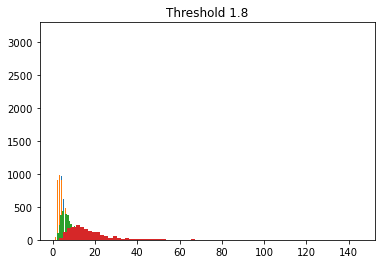

In [26]:
import matplotlib.pyplot as plt

for thresh in [1, 1.2, 1.4, 1.8]:
    cluster_model = cluster(sample, n_clusters=None, distance_threshold=thresh)
    plt.hist([len(v) for v in get_clusters(cluster_model).values()], bins='auto', label=str(thresh))
    plt.title("Threshold " + str(thresh))

In [27]:
def collection_to_clusters(texts, model=model,  **kwargs):
    embs = model.encode(texts, batch_size=64, show_progress_bar=True, convert_to_tensor=True)
    cluster_model = cluster(embs, **kwargs)
    return get_clusters(cluster_model).values()

In [28]:
cluster_tree = {}
lens = [len(v) for v in clusters.values()]
for i, v in clusters.items():
    if len(v) > 25:
        cluster_tree[i] = {"parent" : v}
        cluster_tree[i] = {"children" :[*collection_to_clusters(v, n_clusters=None, distance_threshold=0.7)]}
        #get values, embed and sample again with lower threshold
        

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [32]:
for i,v in cluster_tree.items():
#     print(i)
    for sent in v["children"]:
        3
#         print(sent)
#         print("\n\n")
#     print("-------------- \n\n")

In [34]:
len(get_clusters(cluster_model).keys())

1859

In [46]:
import json

ct = {str(k):v for k,v in cluster_tree.items()}
with open('cluster_tree_34k_tresh_0,4.json', 'w') as outfile:
    json.dump(ct, outfile)
  

In [44]:
cluster_tree.keys()

dict_keys([86, 2010, 4262, 855, 2220, 1570, 2009, 532, 1650, 153, 5908, 8088, 5561, 6310, 2472, 2294, 6267, 5763, 3737, 3616, 2156, 1186, 1940, 2313, 6200, 2226, 6329, 5154, 39, 7855, 502, 3342, 3505, 1294, 1939, 165, 4426, 5661, 4183, 546, 7631, 7881, 2801, 4292, 5163, 6392, 372])

In [33]:
#dict(enumerate(cluster_model.children_, cluster_model.n_leaves_))

## Summarization

**Tried: Google Pegasus**. Result: Does a terrible job of keeping the important information and doesn't retain the question but guesses at a conclusion


In [ ]:
torch.cuda.is_available()

### Pegasus Setup


In [ ]:
from transformers import PegasusForConditionalGeneration, PegasusTokenizer
import torch

model_name = 'google/pegasus-xsum'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
tokenizer = PegasusTokenizer.from_pretrained(model_name)
model = PegasusForConditionalGeneration.from_pretrained(model_name).to(device)


In [ ]:

def summarize(sentences):
    batch = tokenizer(sentences, truncation=True, padding='longest', return_tensors="pt").to(device)
    translated = model.generate(**batch)
    tgt_text = tokenizer.batch_decode(translated, skip_special_tokens=True)
    return tgt_text

### T5 Setup

In [ ]:
from transformers import pipeline

summarizer = pipeline("summarization")

ARTICLE = """ Background: Trust is a critical component of competency committees given their high-stakes decisions. Research from outside of medicine on group trust has not focused on trust in group decisions, and "group trust" has not been clearly defined. The purpose was twofold: to examine the definition of trust in the context of group decisions and to explore what factors may influence trust from the perspective of those who rely on competency committees through a proposed group trust model. Methods: The authors conducted a literature search of four online databases, seeking articles published on trust in group settings. Reviewers extracted, coded, and analyzed key data including definitions of trust and factors pertaining to group trust. Results: The authors selected 42 articles for full text review. Although reviewers found multiple general definitions of trust, they were unable to find a clear definition of group trust and propose the following: a group-directed willingness to accept vulnerability to actions of the members based on the expectation that members will perform a particular action important to the group, encompassing social exchange, collective perceptions, and interpersonal trust. Additionally, the authors propose a model encompassing individual level factors (trustor and trustee), interpersonal interactions, group level factors (structure and processes), and environmental factors."""
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

model = AutoModelForSeq2SeqLM.from_pretrained("snrspeaks/t5-one-line-summary") #snrspeaks/t5-one-line-summary
tokenizer = AutoTokenizer.from_pretrained("snrspeaks/t5-one-line-summary")

# T5 uses a max_length of 512 so we cut the article to 512 tokens.
inputs = tokenizer.encode("summarize: " + ARTICLE, return_tensors="pt", max_length=512, truncation=True)
outputs = model.generate(inputs, max_length=150, min_length=40, length_penalty=2.0, num_beams=4, early_stopping=True)
tokenizer.decode(outputs[0])
def summarize(text):
    inputs = tokenizer.encode("summarize: " + text, return_tensors="pt", max_length=512, truncation=True)
    outputs = model.generate(inputs, max_length=150, min_length=40, length_penalty=2.0, num_beams=4, early_stopping=True)
    return tokenizer.decode(outputs[0])

In [ ]:
summarize("I have seen a ghost in my shed")

In [ ]:
"I have seen a ghost in my shed"[:5]

### Print Results

In [ ]:
for ID, cluster in get_clusters(cluster_model).items():
    sentences = ".".join(cluster)
    print(sentences)
    print( "\n\n", "sum:::", summarize(sentences[:256]), "\n\n\n")
    

In [ ]:
!pip bertopic --version

In [ ]:
!pip uninstall bertopic --yes

In [ ]:
pip uninstall umap
pip install umap-learn

In [ ]:
!pip uninstall bertopic

DEPRECATION: Python 2.7 reached the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 is no longer maintained. pip 21.0 will drop support for Python 2.7 in January 2021. More details about Python 2 support in pip can be found at https://pip.pypa.io/en/latest/development/release-process/#python-2-support pip 21.0 will remove support for this functionality.


In [ ]:
!pip uninstall numpy --yes

Found existing installation: numpy 1.19.5
Uninstalling numpy-1.19.5:
  Successfully uninstalled numpy-1.19.5


## BERTopic topic modeling + set intersection

In [ ]:
from bertopic import BERTopic
m = BERTopic(embedding_model='sentence-transformers/all-mpnet-base-v2', calculate_probabilities=True, verbose=True)

In [ ]:
topics, probs = m.fit_transform(sentences)

Batches:   0%|          | 0/683 [00:00<?, ?it/s]

2021-12-03 16:47:33,124 - BERTopic - Transformed documents to Embeddings
2021-12-03 16:48:05,371 - BERTopic - Reduced dimensionality with UMAP
2021-12-03 16:52:37,941 - BERTopic - Clustered UMAP embeddings with HDBSCAN


In [ ]:
m.get_topic(0)  # Select the most frequent topic

[('delirium', 0.23893908132663674),
 ('icu', 0.060004499282456554),
 ('intensive', 0.025878934150400382),
 ('hospitalized', 0.021585625161763735),
 ('cognition', 0.016149040019138437),
 ('assessment', 0.013744665868210479),
 ('fluctuating', 0.013594127719910273),
 ('picu', 0.012925099644441015),
 ('reversible', 0.01240616115301262),
 ('caring', 0.011313129457092305)]

In [ ]:
m.get_topic(1)  # Select the most frequent topic

[('apnea', 0.18130897695875675),
 ('snoring', 0.06823511579254574),
 ('inspiratory', 0.04325130620318784),
 ('reserpine', 0.027019794584550692),
 ('snore', 0.027019794584550692),
 ('hypopnea', 0.024322723843072304),
 ('respiratory', 0.022186717019186158),
 ('pharmacologic', 0.02162565310159392),
 ('underdiagnosed', 0.020757390256013336),
 ('airways', 0.020047967856036856)]

In [ ]:
#samp = sentences[1100]

def extract_topics(texts, distance_thresh=0.035, model=m):
    topic_labels = model.transform(texts)[0]
    topic_dict = {}
    for idx, ID in enumerate(topic_labels):
        topics = model.get_topic(ID)
        for t in topics:
            topic = t[0]
            dist = t[1]
            if dist > distance_thresh:
                if not topic_dict.get(topic):
                    topic_dict[topic] = [ texts[idx] ] 
                else:
                    sents = topic_dict[topic] + [texts[idx]]
                    topic_dict[topic] = sents
    return topic_dict

In [ ]:
td = extract_topics(sentences)

Batches:   0%|          | 0/683 [00:00<?, ?it/s]

In [ ]:
td

{'memory': ['Another limitation is that only five predefined realisations of REs were used to elicit object descriptions from the participants',
  'Several scientific psychologists consider the approach for the study of perceptive problems of the Experimental Phenomenology is problematic, namely that the phenomenological demonstrations are subjectively based and they do not produce quantifiable results',
  'An inherent problem with such framing of olfactory objecthood is that philosophers explicitly ignore the constitutive factors of the sensory systems that underpin the implementation of these criteria .',
  "One problem with the concept of habit has been that virtually everyone has their own ideas of what is meant by such a term . Whilst not eschewing folk psychology , it is useful to re-examine dictionary definitions of ' habit ' .",
  "A problem with Graves ' task is that it requires memory searching after stimulus presentation , probably reducing the predicted number of items proc

In [ ]:
import json

with open("full_topic_triples.json", "w") as f:
    json.dump(td, f)

## Hierachy by source text overlap


In [ ]:
#take td
#if there's overlap of t1 and t2 t1 is parent if t2 has less of the sources (and 80%+) of t2 sources are in t1 (otherwise duplicate or not that realted))

In [ ]:
def sources_relation(s1, s2, min_overlap=0.7):
    s1 = set(s1)
    s2 = set(s2)
    l1 = len(s1)
    l2 = len(s2)

    common = s1.intersection(s2) #order doesn't matter
    
#     cl1 = len(s1.intersect(common))
#     cl2 = len(s2.intersect(common))
    
    relation="TBA"
    #if only a few sources are common and it's not all/most of one topics sources then -> different ideas
    #if many are common and one topic is much bigger, the smaller is a subtopic
    #if almost all are common and there's 50:50 or 30:70 split then they are duplicates
    #either unrelated, duplicate, or hypernomy
    
    cl = len(common)

    ol2 = cl/l2
    ol1 = cl/l1
    if l1 > l2:
        ol = ol2
    else:
        ol = ol1
    
    if ol < min_overlap: #little in common (one topic is enough to decide)
        relation="different"
        
        #-- comparative
    if ol > min_overlap: #if lots of overlap
        if l2/l1 < 8/10:
            relation="child"
            
            #TODO: use permutations and then filter out duplicates / differents ... (only child left)
        elif l1/l2 < 8/10:
            relation="parent"
        else: #approx similar size
            #topics similar size and much of overlap (synonyms)
            relation = "duplicates"
    
    return relation


In [ ]:
from itertools import combinations

topic_pairs = combinations(td.keys(), 2)
result = [(t1, t2, sources_relation(td[t1], td[t2]) ) for t1,t2 in topic_pairs]


### Building the Tree

In [ ]:
triples = [r for r in result if r[2] == "child" or r[2] == "parent"]

In [ ]:
triples[:8], len(result), len(triples)

([('reperfusion', 'ischemia', 'parent'),
  ('reperfusion', 'ischemic', 'child'),
  ('reperfusion', 'myocardial', 'child'),
  ('reperfusion', 'cerebral', 'child'),
  ('reperfusion', 'perfusion', 'child'),
  ('reperfusion', 'neurons', 'child'),
  ('transplantation', 'nephrotoxicity', 'child'),
  ('transplantation', 'cyclosporine', 'child')],
 378885,
 449)

In [ ]:
#build the tree

def tree_has_topic(topic, tree):
    return len([k for k in FlatterDict(tree).keys() if topic in k]) > 0

def get_leaves(topic, triples):
    node = {}
    node[topic] = {"children": []}
    #topic = node
    for t in triples:
        if (t[0] == topic and t[2] == "child") and not tree_has_topic(t[1], triples): #":or (t[1] == topic and t[2] == "parent")) 
            node[topic]["children"] += [get_leaves(t[1], triples)] 
            
            # TODO: flatten and check if key is already in 
    if len(node[topic]["children"]) == 0: # leave
        return node
    return node

In [ ]:
x = "reperfusion"
[t for t in triples if t[0] == x or t[1] == x]

[('reperfusion', 'ischemia', 'parent'),
 ('reperfusion', 'ischemic', 'child'),
 ('reperfusion', 'myocardial', 'child'),
 ('reperfusion', 'cerebral', 'child'),
 ('reperfusion', 'perfusion', 'child'),
 ('reperfusion', 'neurons', 'child')]

In [ ]:
from flatdict import FlatDict, FlatterDict
y = get_leaves("ischemia", triples)

y

{'ischemia': {'children': [{'vascular': {'children': []}},
   {'limb': {'children': []}},
   {'ischemic': {'children': [{'myocardial': {'children': []}},
      {'cerebral': {'children': []}},
      {'perfusion': {'children': []}},
      {'neurons': {'children': []}}]}},
   {'myocardial': {'children': []}},
   {'cerebral': {'children': []}},
   {'perfusion': {'children': []}},
   {'neurons': {'children': []}},
   {'mesenteric': {'children': []}},
   {'ischaemia': {'children': []}},
   {'intestine': {'children': []}}]}}

In [ ]:
triples[:20]

[('reperfusion', 'ischemia', 'parent'),
 ('reperfusion', 'ischemic', 'child'),
 ('reperfusion', 'myocardial', 'child'),
 ('reperfusion', 'cerebral', 'child'),
 ('reperfusion', 'perfusion', 'child'),
 ('reperfusion', 'neurons', 'child'),
 ('transplantation', 'nephrotoxicity', 'child'),
 ('transplantation', 'cyclosporine', 'child'),
 ('transplantation', 'cyclosporin', 'child'),
 ('transplantation', 'allograft', 'child'),
 ('transplantation', 'gvhd', 'child'),
 ('transplantation', 'shortage', 'child'),
 ('transplantation', 'donor', 'child'),
 ('transplantation', 'donors', 'child'),
 ('transplantation', 'graft', 'child'),
 ('transplantation', 'transplant', 'child'),
 ('transplantation', 'interferon', 'child'),
 ('ischemia', 'vascular', 'child'),
 ('ischemia', 'limb', 'child'),
 ('ischemia', 'ischemic', 'child')]

In [ ]:
trees = {}
for triple in triples:
    #every entity first get's it's children attached before attaching to parent
    topic = triple[0]
    if not trees.get(topic):
        trees[topic] = get_leaves(topic, triples)[topic]

trees

{'reperfusion': {'children': [{'ischemic': {'children': [{'myocardial': {'children': []}},
      {'cerebral': {'children': []}},
      {'perfusion': {'children': []}},
      {'neurons': {'children': []}}]}},
   {'myocardial': {'children': []}},
   {'cerebral': {'children': []}},
   {'perfusion': {'children': []}},
   {'neurons': {'children': []}}]},
 'transplantation': {'children': [{'nephrotoxicity': {'children': []}},
   {'cyclosporine': {'children': []}},
   {'cyclosporin': {'children': []}},
   {'allograft': {'children': []}},
   {'gvhd': {'children': []}},
   {'shortage': {'children': []}},
   {'donor': {'children': []}},
   {'donors': {'children': []}},
   {'graft': {'children': []}},
   {'transplant': {'children': []}},
   {'interferon': {'children': []}}]},
 'ischemia': {'children': [{'vascular': {'children': []}},
   {'limb': {'children': []}},
   {'ischemic': {'children': [{'myocardial': {'children': []}},
      {'cerebral': {'children': []}},
      {'perfusion': {'children':

In [ ]:
for vs in trees["reperfusion"].values():
    for v in vs:
        print([*v.keys()])

['ischemic']
['myocardial']
['cerebral']
['perfusion']
['neurons']


In [ ]:
# default with a level of 0, and an indent of 4 characters
def write(p, depth=0, indent=4):
    if p==None:
        return
    # here we multiply the level by the number of indents
    # and then you multiply that number with a space character
    # which will magically show as that number of spaces.
    print("{}{}".format(" "*(indent*depth), p))
    if p.children!=None:
        # then you do not need your print(…, end='') hack
        # simply increase the depth
        write(p.children, depth=depth+1, indent=indent)

In [ ]:
def walk(node):
    """ iterate tree in pre-order depth-first search order """
   # yield node
    for child in node.children:
        print(child)
        for n in walk(child):
            yield n

In [ ]:
def text_node(node_key, tree):
    text = node_key
    children = tree[node_key].get("children")
    if not children:
        text += "\n\t"
    for child in children:
        text += "\t -->"
        text += text_node([*child.keys()][0], child)
        
    return text

In [ ]:
trees["reperfusion"]

{'children': [{'ischemic': {'children': [{'myocardial': {'children': []}},
     {'cerebral': {'children': []}},
     {'perfusion': {'children': []}},
     {'neurons': {'children': []}}]}},
  {'myocardial': {'children': []}},
  {'cerebral': {'children': []}},
  {'perfusion': {'children': []}},
  {'neurons': {'children': []}}]}

In [ ]:
trees.keys()

dict_keys(['reperfusion', 'transplantation', 'ischemia', 'diabetes', 'gastrointestinal', 'intestinal', 'stress', 'adhesions', 'postoperative', 'pain', 'rhinosinusitis', 'respiratory', 'bone', 'depression', 'depressive', 'disorder', 'diabetic', 'ulcers', 'nausea', 'vomiting', 'chemotherapy', 'medication', 'mental', 'distress', 'ards', 'lung', 'cardiac', 'esophageal', 'osteoporosis', 'fractures', 'postpartum', 'mothers', 'postnatal', 'uti', 'urinary', 'utis', 'coli', 'endodontic', 'dental', 'incontinence', 'hiv', 'immunodeficiency', 'liver', 'surfactant', 'antenatal', 'neonatal', 'infants', 'tbi', 'traumatic', 'brain', 'radiation', 'carcinoma', 'diarrhea', 'diarrheal', 'diarrhoea', 'allergy', 'spinal', 'injury', 'laparoscopic', 'prostate', 'pneumoniae', 'cleft', 'palate', 'lip', 'clefts', 'congenital', 'tuberculosis', 'tb', 'malnutrition', 'intracerebral', 'ich', 'hemorrhage', 'suicidal', 'workplace', 'adolescents', 'dengue', 'drinking', 'alcohol', 'pollution', 'ischemic', 'cartilage', '

In [ ]:
t = """"""
for key in trees.keys():
    t += text_node(key, trees)

In [ ]:
with open('topic_trees.txt', 'w') as f:
    print(t, file=f)

In [ ]:
walk(trees["reperfusion"])

<generator object walk at 0x7fc1a325b150>

In [ ]:

for topic, sources in td.items():
    #every combination gets overlaps
    

disease
inflammatory
gastrointestinal
esophageal
eosinophilic
diseases
disorders
depression
mental
health
suicide
stroke
disability
parkinson
pd
diabetes
diabetic
cardiovascular
myocardial
cancer
skin
infection
tuberculosis
rice
nursing
students
eating
children
overweight
adherence
obesity
medication
